# Python, Centrale Lille, G3 SDIA
---
## Session 3: Brownian motion, Fourier transform

---
## Guidelines (read carefully before starting)


**Objectives**: acquire further practice with common libraries and algorithms (`numpy.fft`, `matplotlib`, `seaborn`).

**Guidelines**: after retrieving the resources for the lab on moodle:
- place the `.zip` archive in a local folder (Computer -> Documents/Python/);
- unzip the archive `.zip`;
- rename the folder with the convention `tp3_Name1_Name2`;
- duplicate the notebook file and rename it `tp3_Name1_Name2.ipynb`;
- [**optional, possibly needed if working from Centrale's machines**]
    - create a `tp3` conda environment from the provided `requirement.txt` file
    ```bash
    conda create --name=tp3 --file=requirement.txt
    conda activate tp3
    # do not forget to deactivate the environment if needed
    # you can remove the environment once you are done
    conda env remove --name=tp3
    ```
    - launch jupyter notebook (the python environment will be the one from the conda environment `tp3`)
- at the end of the session, do not forget to transfer your work to your own network space if you are working on a machine from the school (do not leave your work on the C: drive).

**Assessment** &#8594; global grade from F to A (A+)

This lab session will be evaluated, based on your answer to the exercises reported in a Jupyter notebook (e.g., this one) and any additional `.py` file produced. Any code produced should be commented whenever appropriate, custom functions and objects documented and unit-tested (see session 1). Figure produced should be clearly annotated (axis, title, legend whenever appropriate).

1. Numerical correctness
2. Implementation clarity (documentation, relevance of the comments)
3. Unit-tests developed whenever appropriate (correctness, relevance)
4. Answers to the questions and overall presentation of the Jupyter notebook.

**Useful references for this lab**:

[1] `numpy.random`: [documentation](https://numpy.org/doc/stable/reference/random/index.html?highlight=random#module-numpy.random) 

[2] `numpy.fft`: [documentation](https://numpy.org/doc/stable/reference/routines.fft.html?highlight=fft#module-numpy.fft)

[3] `seaborn`: [tutorial/documentation](https://seaborn.pydata.org/tutorial.html#)


## <a name="content">Contents</a>
- [Exercise 1: Brownian motion](#ex1)
- [Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution](#ex2)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: Brownian motion</a> [(&#8593;)](#content)

This first exercise consists in generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$, focusing first on the 2-D case. The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).

Let $N \in \mathbb{N}^*$, $\delta > 0$, and $\mathbf{x} = (x_1, x_2) \in  \mathcal{B}(\mathbf{0}, 1)$. The first $N$ steps of a 2-D discrete-time Brownian motion $W$ can be generated as follows

\begin{align*}
    W_0 &= \mathbf{x}, \\
    %
    (\forall n \in \{1, \dotsc, N-1 \}), \quad W_n &= W_{n−1} + \sqrt{\delta} G_n, \quad G_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

where $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a Gaussian random distribution with mean $\mathbf{0}$ and identity covariance matrix.

1. Define a random generator `rng`, set to a known state for reproducibility (see session 2).

In [2]:
#Q1
from numpy.random import default_rng
import numpy as np
import pylab as plt 

rng = default_rng(11) #Set the random seed to 11
x = rng.random()  #Generate a pseudo-random number based on seed value in [0,1[
print(x)   #We got the same number when we execute several times

0.12857020276919962


2. Implement a function `brownian_motion(niter, x, step, rng)` which

    - simulates $W$ until it reaches the boundary of $\mathcal{B}(\mathbf{0}, 1)$, using a maximum of $N$ iterations (`niter`), a starting point $\mathbf{x} \in \mathcal{B}(\mathbf{0}, 1)$ (`x`) and step-size $\delta$ (`step`);
    - interpolates linearly between the two last positions to determine the points $W^*$ where the trajectory crosses the boundary (if applicable);
    - returns both the whole random walk $W$ and, if appropriate, the point at the intersection between the last segment of the trajectory and $\mathcal{B}(\mathbf{0}, 1)$.
 
> Hint: 
> - you can easily derive a closed form expression for $W^*$, observing that $\Vert W^* \Vert^2= 1$ and $W^* \in [W_{n-1}, W_n]$. 
> - you can also take a look at [`np.roots`](https://numpy.org/doc/stable/reference/generated/numpy.roots.html?highlight=roots#numpy.roots) if needed.

In [3]:
#Q2
def line_eq(x1,y1,x2,y2):
    m = ( y2-y1 ) / ( x2-x1 )
    p = y1 - m * x1
    return m,p

def circle_line_intersection(radius,m,p,x,y):
    """
    radius = radius of circle
    m, p = equation of line
    x, y = coordinates of the point out of circle, 
           need them to know which of the two intersection points
           the function will return
    """
    x0,y0 = -m*p/(m*m+1), p/(m*m+1)
    d = radius*radius - p*p/(m*m+1)
    mult = np.sqrt (d / (m*m+1))
    ax = x0 - mult
    bx = x0 + mult
    ay = y0 - m * mult
    by = y0 + m * mult
    da = np.sqrt((x-ax)**2+(y-ay)**2) #Distance between intersection a and the point outside the circle
    db = np.sqrt((x-bx)**2+(y-by)**2) #Distance between intersection b and the point outside the circle
    if (da<db): #Return the intersection which is the closest to the point outside the circle
        return ax,ay
    return bx,by

def brownian_motion(niter, x, step, rng):
    walk_x, walk_y = np.zeros(niter), np.zeros(niter)
    walk_x[0], walk_y[0] = x[0], x[1]
    for n in range (1, niter):
        x[0] += np.sqrt(step)*rng.normal(0,1)
        x[1] += np.sqrt(step)*rng.normal(0,1)
        walk_x[n], walk_y[n] = x[0], x[1]
        if(np.sqrt(x[0]**2+x[1]**2)>1):
            x1,y1 = walk_x[n-1], walk_y[n-1]
            x2,y2 = walk_x[n], walk_y[n]
            m,p = line_eq(x1,y1,x2,y2) #equation of line crossing the circle
            ax,ay = circle_line_intersection(1,m,p,x2,y2) #coordinates of intersection of circle and line
            return walk_x[0:n+1],walk_y[0:n+1],np.array((ax,ay)) 
    return walk_x,walk_y,np.array((0,0)) #if trajectory never cross the circle boundaries, return (0,0)

3. Diplay the trajectory of a Brownian motion starting from $\mathbf{x} = (0.2, 0.4)$, using $\delta = 10^{-2}$, $N = 1000$. Display the unit circle on the same figure, and highlight the intersection with the boundary of the domain (whenever it exists).

> Hint: to draw the unit disk, you can use for instance:
> ```python
> circle = plt.Circle((0,0), 1)
> fig, ax = plt.subplots()
> plt.xlim(-1.25,1.25)
> plt.ylim(-1.25,1.25)
> plt.grid(linestyle = "--", zorder = 1)
> ax.set_aspect(1)
> ax.add_artist(circle)
> ```

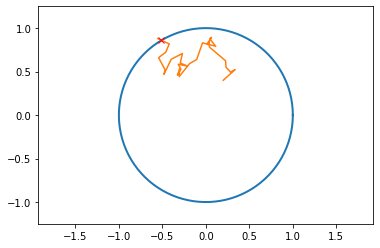

In [4]:
#Q3
x = np.array((0.2,0.4))
delta = 10**-2
N = 1000
w_x,w_y,intersection = brownian_motion(N, x, delta, rng)
    

#make a simple unit circle 
theta = np.linspace(0, 2*np.pi, 100)
a, b = np.cos(theta), np.sin(theta)
plt.plot(a, b, linestyle='-', linewidth=2, label='Circle')
#plot the trajectory of Brownian motion
plt.plot(w_x,w_y)
#plot the intersection with boundary if it exists
if ((intersection!=np.array((0,0))).all()):
    plt.plot(intersection[0],intersection[1],'rx') 
plt.axis('equal')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.show()

4. Represent, on the same figure, 4 other trajectories of $W$ with the same parameters.

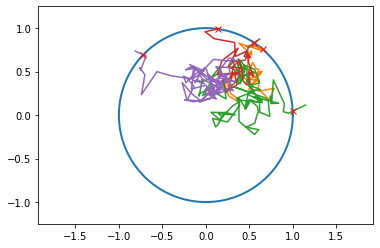

In [5]:
#make a simple unit circle 
theta = np.linspace(0, 2*np.pi, 100)
a, b = np.cos(theta), np.sin(theta)
plt.plot(a, b, linestyle='-', linewidth=2, label='Circle')

delta = 10**-2
N = 1000
for i in range(5):
    w_x,w_y,intersection = brownian_motion(N, np.array((0.2,0.4)), delta, rng)
    #plot the trajectory of Brownian motion
    plt.plot(w_x,w_y)
    #plot the intersection with boundary if it exists
    if ((intersection!=np.array((0,0))).all()):
        plt.plot(intersection[0],intersection[1],'rx')

plt.axis('equal')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.show()
    

5. [Bonus] Generalize the procedure to a $M$-dimensional Brownian motion, $M > 2$.

In [6]:
# your anwer(s)

---
## <a name="ex2">Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution</a> [(&#8593;)](#content)

In this exercise, we explore the use of the 2-dimensional Fourier transform to filter an image, and convolve it with a blurring kernel.

1\. Load and display one of the images contained in the `img/` folder. The image will be denoted by $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ in the rest of this exercise.

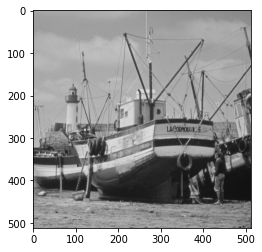

In [7]:
#Q1
from PIL import Image
img = Image.open('img/boat.png')
plt.imshow(img)
plt.show()

2\. Let $\mathcal{F}$ denote the 2D Fourier transform. Compute $|\mathcal{F}(\mathbf{X})|^2$, the spectrum of the image $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ (i.e., the term-wise squared absolute value of its Fourier transform) loaded in 1. Display the result in logarithmic scale.

a) In this representation, where is the pixel of the spectrum associated with the null frequency located?
    
b) Take a look at the documentation of `np.fft.fftshift`. Use it to ensure that the null frequency is located at the center of the image. 

5.243018986080558 1273406806650276.0


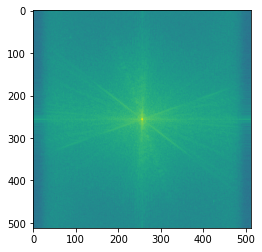

In [8]:
#Q2
from matplotlib.colors import LogNorm

f = np.fft.fft2(img) #2D Fourier Transform
fshift = np.fft.fftshift(f) #Shift f so that the null frequency is centered
spectrum = np.abs(fshift)**2 #|F(X)|²
print(np.min(spectrum), np.max(spectrum))
#plt.imshow(spectrum)
plt.imshow(spectrum, norm=LogNorm(vmin=1e-3))

3\. 
    a) Create a function `ideal_lowpass_filter` to filter $\mathbf{X}$ by an ideal low-pass filter. The filter preserves Fourier coefficients associated to frequencies below a cutoff specified in each direction ($\mathbf{f}_c = (f_{c,y}, f_{c,x})$), and sets others to zero. For simplicity, $f_{c,y}$ and $f_{c,x}$ can be expressed as a number of samples to be kept along each dimension (e.g., $\mathbf{f}_c = (50,50)$).

b) Display the filtered image for 2 different values of $\mathbf{f}_c$. What do you observe as the cutoff frequencies increase?
    
> Warning: beware the type of the array after `np.fft.fft2`, do not hesitate to specify the type if you make copies from this array
> ```python
> a = np.zeros((2,2), dtype=np.complex)
> ...
> ```

In [29]:
#Q3
def ideal_lowpass_filter(X ,f_cy, f_cx):
    X_filtered = np.zeros(np.shape(X), dtype = np.complex)
    for i in range (f_cy):
        X_filtered[i][0:f_cx] = [X[i][k] for k in range(f_cx)]
    return X_filtered

filtered_f = ideal_lowpass_filter(f, 200, 200)
print(filtered_f[0:201,0:201])
filtered_fshift = np.fft.fftshift(filtered_f) #Shift f so that the null frequency is centered
print(filtered_fshift)
#filtered_fshift = ideal_lowpass_filter(fshift, 200, 200)
filtered_spectrum = np.abs(filtered_fshift)**2 #|F(X)|²
print(filtered_spectrum[190:210,190:210])
#plt.imshow(filtered_spectrum, norm=LogNorm(vmin=1e-3))

[[ 3.56848260e+07+0.00000000e+00j  5.59087013e+03-1.82468574e+06j
  -1.64608899e+05-3.77164258e+04j ...  1.48021260e+04+4.43129632e+03j
   6.75827775e+03-5.72257780e+03j  0.00000000e+00+0.00000000e+00j]
 [-2.42598753e+05-5.77268984e+06j  9.46453076e+05-3.01148043e+03j
  -2.02253143e+05-2.93884338e+05j ...  1.31572372e+03-1.28507451e+04j
   1.16269746e+04+1.12195533e+04j  0.00000000e+00+0.00000000e+00j]
 [ 2.29860286e+06-9.61975431e+05j -1.52884459e+02+1.02254813e+06j
   5.29577162e+05-4.33568930e+05j ... -6.75598962e+03+1.17427602e+04j
  -1.34376126e+04+2.61592846e+03j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 6.37158786e+03-1.86068921e+03j  3.96154989e+02-1.21661341e+03j
   1.20635840e+03+4.72297381e+02j ... -6.97885607e+02-1.11271541e+03j
  -1.04761646e+03+4.63879467e+02j  0.00000000e+00+0.00000000e+00j]
 [ 6.38294410e+03+3.33212469e+02j  2.18994911e+03-3.35862131e+03j
   3.20840494e+03-6.42918822e+02j ...  1.84966281e+02-4.13999932e+02j
  -2.92000937e+03-9.06321262e+02j  0.00000000e+

4\. Let $\mathbf{H} \in \mathbb{R}^{M_2\times N_2}$ be a 2-D Gaussian kernel, obtained as the outer product of two 1-D Gaussian windows $\mathbf{w}_y \in \mathbb{R}^{M_2}$ and $\mathbf{w}_x \in \mathbb{R}^{N_2}$, of standard deviation $\sigma_y = 10$ and $\sigma_x = 10$, respectively:

\begin{equation}
    \mathbf{H} = \mathbf{w}_y \mathbf{w}_x^T.
\end{equation}

Let $M = M_1+M_2-1$ and $N =  N_1+N_2-1$. From the discrete convolution theorem, the linear convolution between $\mathbf{H}$ and $\mathbf{X}$ can be computed as follows

\begin{equation}
    \mathbf{X} \star \mathbf{H} = \mathcal{F}^{-1} \Big( \mathcal{F}\big(P_1(\mathbf{X})\big) \odot \mathcal{F}\big(P_2(\mathbf{H})\big) \Big) \in \mathbb{R}^{M\times N},
\end{equation}

where $P_i: \mathbb{R}^{M_i \times N_i} \rightarrow \mathbb{R}^{M \times N}$, $i \in \{1, 2\}$, are 0-padding operators, $\odot$ is the Hadamard (= term-wise) product and $\mathcal{F}^{-1}$ is the inverse Fourier transform. 

Compute and display $\mathbf{X} \star \mathbf{H}$, for $M_2 = N_2 = 10$. What do you observe?

> Hint: 
> - since the input images are real, $\mathcal{F}(\mathbf{x})$ and $\mathcal{F}(\mathbf{h})$ are Hermitian symmetric. In this case, a more efficient version of `np.fft.fft` can be used, computing only half of the Fourier coefficients: [`np.fft.rfft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html?highlight=rfft#numpy.fft.rfft). Its inverse, [`np.fft.irfft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft.html), also ensures that the output is real;
> - the 2D Gaussian window can be generated as the Hadamard product of two 1D Gaussian windows (one window for each dimension);
> - you can take a look at [scipy.signal.windows.gaussian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian) and [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis).

In [10]:
# your anwer(s)